In [1]:
import numpy as np
import os,sys
sys.path.append('..')
from trainer import Trainer
from config import get_config
from utils import *
import pickle
import matplotlib.pyplot as plt
import math
from tqdm import trange
#from re_main import main
#from trainer import *

from pprint import pprint
from models import *

/home/slcf/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def norm_img(img):
    img = img/255.0
    return img
def denorm_img(img):
    return tf.clip_by_value(img*255.0,0,255)


In [3]:
def corrupt_np(x,noise_type='gaussian',noise_param=0.1):
    noise = np.random.normal(scale = noise_param,size = x.shape)
    corrupted = np.clip(x+noise,0.0,1.0)
    return corrupted

In [4]:
crrX = corrupt_np(x_train/255.0)
n=10
plt.figure(figsize = (20,4))
for i in range(n):
    # Display Original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(x_train[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax .get_yaxis().set_visible(False)
    
    # Display Reconstruction
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(crrX[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

NameError: name 'x_train' is not defined

In [4]:
def corrupt(x, noise_type='gaussian',noise_param=0.01):
    if noise_type=='corrupt':
        mask_dist = dist.Bernoulli(probs=1-noise_param,dtype=tf.float32)
        mask = mask_dist.sample(sample_shape=tf.shape(x))
        corrupted = tf.multiply(x,mask)    
    elif noise_type == 'pipSalt':
        noise_dist = dist.Categorial(probs=[noise_paaram/2.1-noise_param,noise_param/2])
        noise = tf.cast(noise_dist.sample(sample_shape = tf.shape(x))-1,dtype = tf.float32)
        corrupted = tf.clip_by_value(tf.add(x,noise),0.0,1.0)
    else:
        noise = tf.random_normal(shape=tf.shape(x),mean=0.0,stddev = noise_param)
        corrupted = tf.clip_by_value(tf.add(x,noise),0.0,1.0)
        
    return corrupted
        

In [5]:
def AE_dense(X=None,dims = [784,1024,1024],activation=tf.nn.elu,tied=False):
    shapeX = X.shape
    with tf.variable_scope("AE_dense") as vs:
        z = tf.reshape(X,[-1,np.prod(shapeX[1:])])
        for idx, n_output in enumerate(dims[1:]):
            z = slim.fully_connected(z,n_output,activation_fn = activation)
            z = slim.batch_norm(z)
            
        rx = z
        for idx, n_output in enumerate(dims[:-1][::-1]):
            if idx<len(dims)-2:
                rx = slim.fully_connected(rx,n_output,activation_fn = activation)
                rx = slim.batch_norm(rx)
            else:
                rx_z = rx
                rx = slim.fully_connected(rx,n_output,activation_fn = tf.nn.sigmoid)
    variables = tf.contrib.framework.get_variables(vs)
    return rx, z, rx_z, variables
    

In [6]:
### parameter specification ###
layers = [784,1024,1024]
lr_init = 0.1
lr_step = 100
lr_decay = 0.1
iterations = 10000
batch_size = 128
model_dir = '../logs/mnist_denseDAE'

In [7]:
tf.reset_default_graph()
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train = np.array(x_train,dtype=np.float32)
x_test = np.array(x_test,dtype=np.float32)
print(x_train.dtype)

float32


In [8]:
def next_batch_dae(num, x, y):
    idx = np.arange(0 , len(x))
    np.random.shuffle(idx)
    idx = idx[:num]
    x_shuffle = [x[ i] for i in idx]
    y_shuffle = [y[ i] for i in idx]

    return np.asarray(x_shuffle), np.asarray(y_shuffle)

In [9]:
def create_model():
    tf.reset_default_graph()
    step_var = tf.Variable(0,name='step',trainable=False)
    lr = tf.train.exponential_decay(lr_init, step_var, lr_step,lr_decay,staircase=True)


    image_batch = tf.placeholder(tf.float32,shape=[batch_size,28,28])
    batch_X = norm_img(image_batch)
    crrX = corrupt(batch_X)#defualt is gaussian
    batch_crrX = denorm_img(crrX)


    x = tf.reshape(batch_X,[-1,layers[0]])
    rx,z, variables = AE_dense(crrX,layers,tf.nn.elu)
    batch_rx = denorm_img(rx)
    optimizer = tf.train.AdamOptimizer(lr)
    loss = tf.reduce_mean(tf.abs(rx-x))
    optim = optimizer.minimize(loss,var_list = variables)
    summary_op = tf.summary.merge([
        tf.summary.scalar("loss",loss),
        tf.summary.scalar("lr",lr)
    ])

    init_op = tf.global_variables_initializer()

In [10]:
#Reset default graph 하면 이전에 정의해 놓았던 tensor들이 모호해 지므로 적당한 위치에
#놓는 것이 매우 중요하다.

step_var = tf.Variable(0,name='step',trainable=False)
lr = tf.train.exponential_decay(lr_init, step_var, lr_step,lr_decay,staircase=True)


image_batch = tf.placeholder(tf.float32,shape=[batch_size,28,28])
batch_X = norm_img(image_batch)
crrX = corrupt(batch_X,'gaussian',0.2)#defualt is gaussian
batch_crrX = denorm_img(crrX)


x = tf.reshape(batch_X,[-1,layers[0]])
rx,z,rx_z, variables = AE_dense(crrX,layers,tf.nn.elu)
batch_rx = denorm_img(rx)
optimizer = tf.train.AdamOptimizer(lr)
#loss = tf.reduce_mean(tf.abs(rx-x))
loss = tf.reduce_mean(tf.square(rx-x))
optim = optimizer.minimize(loss,var_list = variables)
summary_op = tf.summary.merge([
    tf.summary.scalar("loss",loss),
    tf.summary.scalar("lr",lr)
])

init_op = tf.global_variables_initializer()
saver = tf.train.Saver()
"""
summary_writer = tf.summary.FileWriter(model_dir)
sv = tf.train.Supervisor(logdir = model_dir,
                        is_chief = True, saver = saver,
                        summary_op = summary_op,
                        summary_writer = summary_writer,
                        save_model_secs = 100,
                        global_step = step_var,
                        ready_for_local_init_op = None)
gpu_options = tf.GPUOptions(allow_growth = True)
sess_config = tf.ConfigProto(allow_soft_placement=True,
                            gpu_options = gpu_options)
"""

'\nsummary_writer = tf.summary.FileWriter(model_dir)\nsv = tf.train.Supervisor(logdir = model_dir,\n                        is_chief = True, saver = saver,\n                        summary_op = summary_op,\n                        summary_writer = summary_writer,\n                        save_model_secs = 100,\n                        global_step = step_var,\n                        ready_for_local_init_op = None)\ngpu_options = tf.GPUOptions(allow_growth = True)\nsess_config = tf.ConfigProto(allow_soft_placement=True,\n                            gpu_options = gpu_options)\n'

In [13]:
#create_model()
#saver = tf.train.Saver()
with tf.Session() as sess:
    #coord = tf.train.Coordinator()
    #threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    sess.run(init_op)
    start_step = sess.run(step_var)
    for itr in trange(start_step,iterations):
        fetch_dict={
            'optim':optim
        }
        if itr%100==0:
            fetch_dict.update({
                "summary": summary_op,
                "loss":loss,
                "lr":lr
            })
        feed_dict = {
            image_batch: next_batch_dae(batch_size,x_train,y_train)[0]
        }
        result = sess.run(fetch_dict,feed_dict)
        #print("sess end")
        if itr%100==0:
            print("[{}/{}] Loss:{:.6f}".format(itr,iterations,result["loss"]))
        if itr%1000==999:
            save_path = saver.save(sess,model_dir+str(itr)+".ckpt",global_step = step_var)
    batch_img,noise_img,recon_img,trrx,trx,latent_z,latent_xz = sess.run([batch_X,batch_crrX,batch_rx,rx,x,z,rx_z],feed_dict = {image_batch:x_test[:batch_size]})
    #coord.request_stop()
    #coord.join(threads)

  0%|          | 24/10000 [00:00<01:26, 115.71it/s]

[0/10000] Loss:0.277754


  1%|▏         | 134/10000 [00:00<01:00, 162.62it/s]

[100/10000] Loss:0.068456


  2%|▏         | 227/10000 [00:01<00:57, 169.59it/s]

[200/10000] Loss:0.061190


  3%|▎         | 336/10000 [00:01<00:56, 172.20it/s]

[300/10000] Loss:0.057734


  4%|▍         | 431/10000 [00:02<00:55, 173.95it/s]

[400/10000] Loss:0.055505


  5%|▌         | 522/10000 [00:02<00:54, 174.49it/s]

[500/10000] Loss:0.049868


  6%|▋         | 631/10000 [00:03<00:53, 175.05it/s]

[600/10000] Loss:0.051831


  7%|▋         | 723/10000 [00:04<00:52, 175.55it/s]

[700/10000] Loss:0.049550


  8%|▊         | 834/10000 [00:04<00:52, 175.99it/s]

[800/10000] Loss:0.048911


  9%|▉         | 928/10000 [00:05<00:51, 176.41it/s]

[900/10000] Loss:0.049247


 10%|█         | 1019/10000 [00:05<00:51, 172.79it/s]

[1000/10000] Loss:0.049701


 11%|█▏        | 1130/10000 [00:06<00:51, 173.59it/s]

[1100/10000] Loss:0.044111


 12%|█▏        | 1220/10000 [00:07<00:50, 173.73it/s]

[1200/10000] Loss:0.045529


 13%|█▎        | 1328/10000 [00:07<00:49, 173.64it/s]

[1300/10000] Loss:0.047629


 14%|█▍        | 1437/10000 [00:08<00:49, 173.99it/s]

[1400/10000] Loss:0.044684


 15%|█▌        | 1532/10000 [00:08<00:48, 174.36it/s]

[1500/10000] Loss:0.044828


 16%|█▋        | 1625/10000 [00:09<00:47, 174.52it/s]

[1600/10000] Loss:0.045939


 17%|█▋        | 1736/10000 [00:09<00:47, 174.84it/s]

[1700/10000] Loss:0.049140


 18%|█▊        | 1830/10000 [00:10<00:46, 175.08it/s]

[1800/10000] Loss:0.044375


 19%|█▉        | 1922/10000 [00:10<00:46, 175.26it/s]

[1900/10000] Loss:0.045751


 20%|██        | 2031/10000 [00:11<00:45, 173.77it/s]

[2000/10000] Loss:0.044552


 21%|██        | 2121/10000 [00:12<00:45, 173.89it/s]

[2100/10000] Loss:0.043087


 22%|██▏       | 2229/10000 [00:12<00:44, 173.90it/s]

[2200/10000] Loss:0.040979


 23%|██▎       | 2319/10000 [00:13<00:44, 173.77it/s]

[2300/10000] Loss:0.043660


 24%|██▍       | 2426/10000 [00:13<00:43, 173.58it/s]

[2400/10000] Loss:0.043992


 25%|██▌       | 2528/10000 [00:14<00:43, 173.37it/s]

[2500/10000] Loss:0.043583


 26%|██▋       | 2630/10000 [00:15<00:42, 173.04it/s]

[2600/10000] Loss:0.045731


 27%|██▋       | 2732/10000 [00:15<00:42, 172.74it/s]

[2700/10000] Loss:0.040560


 28%|██▊       | 2834/10000 [00:16<00:41, 172.48it/s]

[2800/10000] Loss:0.044937


 29%|██▉       | 2919/10000 [00:16<00:41, 172.29it/s]

[2900/10000] Loss:0.046052


 30%|███       | 3023/10000 [00:17<00:40, 171.05it/s]

[3000/10000] Loss:0.042505


 31%|███▏      | 3133/10000 [00:18<00:40, 171.27it/s]

[3100/10000] Loss:0.044122


 32%|███▏      | 3223/10000 [00:18<00:39, 171.26it/s]

[3200/10000] Loss:0.040975


 33%|███▎      | 3326/10000 [00:19<00:39, 171.06it/s]

[3300/10000] Loss:0.041373


 34%|███▍      | 3428/10000 [00:20<00:38, 170.86it/s]

[3400/10000] Loss:0.043151


 35%|███▌      | 3530/10000 [00:20<00:37, 170.65it/s]

[3500/10000] Loss:0.042036


 36%|███▋      | 3632/10000 [00:21<00:37, 170.45it/s]

[3600/10000] Loss:0.040819


 37%|███▋      | 3717/10000 [00:21<00:36, 170.30it/s]

[3700/10000] Loss:0.041292


 38%|███▊      | 3819/10000 [00:22<00:36, 170.13it/s]

[3800/10000] Loss:0.043639


 39%|███▉      | 3921/10000 [00:23<00:35, 169.92it/s]

[3900/10000] Loss:0.040771


 40%|████      | 4025/10000 [00:23<00:35, 169.08it/s]

[4000/10000] Loss:0.042092


 41%|████      | 4119/10000 [00:24<00:34, 169.36it/s]

[4100/10000] Loss:0.043632


 42%|████▏     | 4227/10000 [00:24<00:34, 169.52it/s]

[4200/10000] Loss:0.042204


 43%|████▎     | 4335/10000 [00:25<00:33, 169.58it/s]

[4300/10000] Loss:0.040202


 44%|████▍     | 4425/10000 [00:26<00:32, 169.58it/s]

[4400/10000] Loss:0.043848


 45%|████▌     | 4527/10000 [00:26<00:32, 169.45it/s]

[4500/10000] Loss:0.042089


 46%|████▋     | 4629/10000 [00:27<00:31, 169.40it/s]

[4600/10000] Loss:0.045399


 47%|████▋     | 4735/10000 [00:27<00:31, 169.41it/s]

[4700/10000] Loss:0.041830


 48%|████▊     | 4821/10000 [00:28<00:30, 169.39it/s]

[4800/10000] Loss:0.041181


 49%|████▉     | 4925/10000 [00:29<00:29, 169.37it/s]

[4900/10000] Loss:0.039756


 50%|█████     | 5031/10000 [00:29<00:29, 168.80it/s]

[5000/10000] Loss:0.042440


 51%|█████     | 5121/10000 [00:30<00:28, 168.95it/s]

[5100/10000] Loss:0.037911


 52%|█████▏    | 5229/10000 [00:30<00:28, 169.11it/s]

[5200/10000] Loss:0.041777


 53%|█████▎    | 5319/10000 [00:31<00:27, 169.22it/s]

[5300/10000] Loss:0.042123


 54%|█████▍    | 5427/10000 [00:32<00:27, 169.27it/s]

[5400/10000] Loss:0.038955


 55%|█████▌    | 5517/10000 [00:32<00:26, 169.28it/s]

[5500/10000] Loss:0.039708


 56%|█████▌    | 5622/10000 [00:33<00:25, 169.26it/s]

[5600/10000] Loss:0.042531


 57%|█████▋    | 5724/10000 [00:33<00:25, 169.18it/s]

[5700/10000] Loss:0.042130


 58%|█████▊    | 5834/10000 [00:34<00:24, 169.33it/s]

[5800/10000] Loss:0.039848


 59%|█████▉    | 5928/10000 [00:34<00:24, 169.50it/s]

[5900/10000] Loss:0.040304


 60%|██████    | 6023/10000 [00:35<00:23, 169.15it/s]

[6000/10000] Loss:0.042500


 61%|██████▏   | 6137/10000 [00:36<00:22, 169.40it/s]

[6100/10000] Loss:0.041760


 62%|██████▏   | 6232/10000 [00:36<00:22, 169.56it/s]

[6200/10000] Loss:0.042692


 63%|██████▎   | 6324/10000 [00:37<00:21, 169.66it/s]

[6300/10000] Loss:0.040081


 64%|██████▍   | 6432/10000 [00:37<00:21, 169.76it/s]

[6400/10000] Loss:0.040632


 65%|██████▌   | 6526/10000 [00:38<00:20, 169.91it/s]

[6500/10000] Loss:0.041833


 66%|██████▋   | 6635/10000 [00:39<00:19, 170.02it/s]

[6600/10000] Loss:0.040927


 67%|██████▋   | 6727/10000 [00:39<00:19, 170.15it/s]

[6700/10000] Loss:0.041272


 68%|██████▊   | 6822/10000 [00:40<00:18, 170.29it/s]

[6800/10000] Loss:0.041946


 69%|██████▉   | 6936/10000 [00:40<00:17, 170.45it/s]

[6900/10000] Loss:0.040792


 70%|███████   | 7027/10000 [00:41<00:17, 170.10it/s]

[7000/10000] Loss:0.040133


 71%|███████   | 7120/10000 [00:41<00:16, 170.22it/s]

[7100/10000] Loss:0.038444


 72%|███████▏  | 7232/10000 [00:42<00:16, 170.36it/s]

[7200/10000] Loss:0.039587


 73%|███████▎  | 7327/10000 [00:42<00:15, 170.48it/s]

[7300/10000] Loss:0.037623


 74%|███████▍  | 7435/10000 [00:43<00:15, 170.58it/s]

[7400/10000] Loss:0.041041


 75%|███████▌  | 7525/10000 [00:44<00:14, 170.63it/s]

[7500/10000] Loss:0.041543


 76%|███████▋  | 7633/10000 [00:44<00:13, 170.65it/s]

[7600/10000] Loss:0.041376


 77%|███████▋  | 7723/10000 [00:45<00:13, 170.64it/s]

[7700/10000] Loss:0.041037


 78%|███████▊  | 7825/10000 [00:45<00:12, 170.59it/s]

[7800/10000] Loss:0.041652


 79%|███████▉  | 7927/10000 [00:46<00:12, 170.53it/s]

[7900/10000] Loss:0.039620


 80%|████████  | 8031/10000 [00:47<00:11, 170.10it/s]

[8000/10000] Loss:0.037729


 81%|████████  | 8121/10000 [00:47<00:11, 170.17it/s]

[8100/10000] Loss:0.038592


 82%|████████▏ | 8229/10000 [00:48<00:10, 170.20it/s]

[8200/10000] Loss:0.041467


 83%|████████▎ | 8319/10000 [00:48<00:09, 170.20it/s]

[8300/10000] Loss:0.042235


 84%|████████▍ | 8423/10000 [00:49<00:09, 170.17it/s]

[8400/10000] Loss:0.037968


 85%|████████▌ | 8526/10000 [00:50<00:08, 170.14it/s]

[8500/10000] Loss:0.038670


 86%|████████▋ | 8632/10000 [00:50<00:08, 170.15it/s]

[8600/10000] Loss:0.042299


 87%|████████▋ | 8722/10000 [00:51<00:07, 170.16it/s]

[8700/10000] Loss:0.039331


 88%|████████▊ | 8831/10000 [00:51<00:06, 170.21it/s]

[8800/10000] Loss:0.039930


 89%|████████▉ | 8926/10000 [00:52<00:06, 170.34it/s]

[8900/10000] Loss:0.039262


 90%|█████████ | 9021/10000 [00:53<00:05, 170.10it/s]

[9000/10000] Loss:0.039248


 91%|█████████▏| 9135/10000 [00:53<00:05, 170.24it/s]

[9100/10000] Loss:0.037772


 92%|█████████▏| 9230/10000 [00:54<00:04, 170.35it/s]

[9200/10000] Loss:0.038284


 93%|█████████▎| 9325/10000 [00:54<00:03, 170.45it/s]

[9300/10000] Loss:0.037704


 94%|█████████▍| 9420/10000 [00:55<00:03, 170.56it/s]

[9400/10000] Loss:0.038408


 95%|█████████▌| 9534/10000 [00:55<00:02, 170.70it/s]

[9500/10000] Loss:0.037980


 96%|█████████▋| 9629/10000 [00:56<00:02, 170.82it/s]

[9600/10000] Loss:0.040983


 97%|█████████▋| 9724/10000 [00:56<00:01, 170.92it/s]

[9700/10000] Loss:0.038628


 98%|█████████▊| 9819/10000 [00:57<00:01, 171.01it/s]

[9800/10000] Loss:0.040244


 99%|█████████▉| 9932/10000 [00:58<00:00, 171.11it/s]

[9900/10000] Loss:0.038958


100%|██████████| 10000/10000 [00:58<00:00, 170.83it/s]


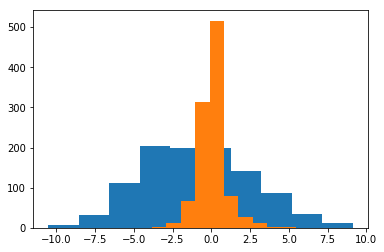

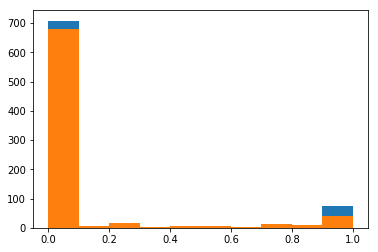

In [17]:
#print(latent_z[0][latent_z[0]>0.5])
plt.hist(latent_z[0])
plt.hist(latent_xz[0])
#plt.hist(recon_img[0])
plt.show()
#plt.hist(recon_img[0])
plt.hist(trrx[0])
plt.hist(trx[0])
plt.show()

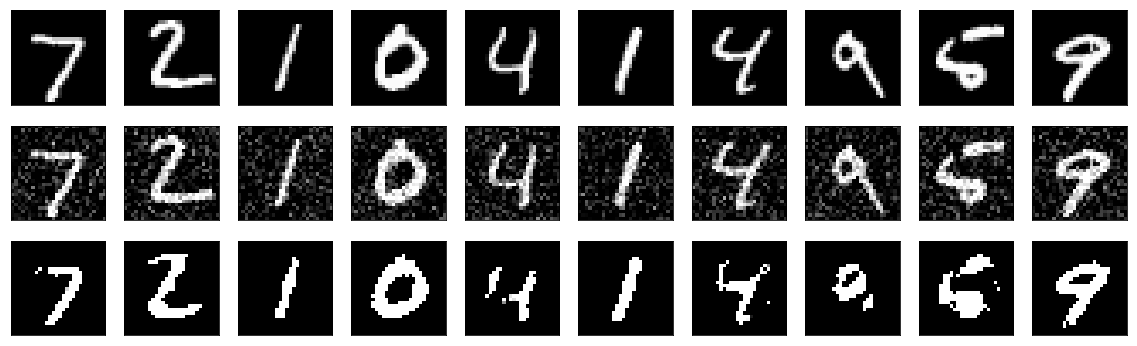

In [12]:
"""
with tf.Session() as sess:
    create_model()
    latest = tf.train.latest_checkpoint(model_dir)
    saver.restore(sess,latest)
    noise_img,recon_img = sess.run([batch_crrX,batch_rx],feed_dict = {image_batch:x_test[:batch_size]})
#encoded_imgs = encoder.predict(x_test)
#decoded_imgs = autoencoder.predict(x_test)
"""
n=10
plt.figure(figsize = (20,6))
for i in range(n):
    # Display Original
    ax = plt.subplot(3,n,i+1)
    plt.imshow(batch_img[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax .get_yaxis().set_visible(False)
    
    ax = plt.subplot(3,n,i+1+n)
    plt.imshow(noise_img[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax .get_yaxis().set_visible(False)
    
    # Display Reconstruction
    ax = plt.subplot(3,n,i+1+2*n)
    plt.imshow(recon_img[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
## Train the classifier
#1. SVM
#2. DNN
def DNN_mnist(x):
    

In [16]:
#image_batch, label_batch = tf.train.shuffle_batch(
#[X,y],
#batch_size = 64,
#num_threads = 4,
#capacity = 5000,
#enqueue_many=True,
#min_after_dequeue = 100,name = 'training_data')
#image_batch = tf.to_float(image_batch)
#label_batch = tf.to_float(label_batch)
def next_batch(datasets,batch_size):
    if type(datasets)==list:
        ndata = datasets[0].shape[0]
        print(ndata)
        #idx = list(range(ndata))
        #idx = tf.random_shuffle(idx)
        shf_image = tf.random_shuffle(datasets[0])
        seed = tf.get_seed(idx)
        shf_label = tf.random_shuffle(datasets[1],seed = seed)
        return shf_image[:batch_size],shf_label[:batch_size]
    else:
        ndata = datasets.shape[0]
        idx = list(np.range(ndata))
        tf.random_shuffle(idx)
        return datasets[idx][:batch_size]
            

In [70]:
X = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
y = tf.constant([1,2,3,4])
#datasets = tf.concat([X,tf.reshape(y,[-1,1])],axis=1)
#seed = tf.random_uniform((1,),12345678)
#print(seed)
#shfT = tf.random_shuffle(datasets)
#print(shfT)
#print(shfy)
shfX = tf.random_shuffle(X,seed=1)
print(tf.get_seed(111))
shfy = tf.random_shuffle(y,seed=1)
print(tf.get_seed(shfy))
#shfX = shfT[:,:-1]
#shfy = shfT[:,-1]
with tf.Session() as sess:
    print(sess.run(X))
    print(sess.run(y))
    #print(sess.run(datasets))
    #print(sess.run(shfT))
    print(sess.run(shfX))
    print(sess.run(shfy))
    print(sess.run(tf.get_seed(shfy)[1]))

(87654321, 111)
(87654321, <tf.Tensor 'mod_15:0' shape=(4,) dtype=int32>)
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]
[1 2 3 4]
[[10 11 12]
 [ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]]
[4 1 2 3]
[2 4 3 1]
